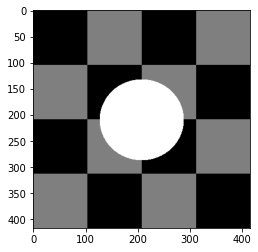

In [60]:
from PIL import Image
import imageio
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

COLOR_CLASSES = [0, 127, 255]
CLASSES = [0, 1, 2]
four_neighbors_related_positions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
eight_neighbors_related_positions = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]

path = '../data/test1.bmp'
image = imageio.imread(path, as_gray=True)
plt.imshow(image, cmap='gray')
true_labels = get_class_labels(data=image)

## Part A

In [27]:
def make_noisy(image, mean, var):
    sigma = var ** 0.5
    gaussian = np.random.normal(mean, sigma, image.shape)
    gaussian = gaussian.reshape(image.shape)
    return image + gaussian


def get_class_labels(data: []):
    labels = np.zeros((len(data), len(data[0])))
    for row in range(len(data)):
        for col in range(len(data[0])):
            if data[row][col] < 85:
                label = 0
            elif data[row][col] < 170:
                label = 1
            else:
                label = 2
            labels[row][col] = label

    return labels


def get_class_information(data: [], labels: []):
    data_info = {}
    class_info = {}

    for c in CLASSES:
        data_info[c] = {
            'data': [],
            'mean': 0,
            'var': 0,
            'probability': 0
        }

        class_info[c] = {
            'mean': 0,
            'var': 0,
            'probability': 0
        }

    for c in CLASSES:
        for row in range(len(data)):
            for col in range(len(data[0])):
                if labels[row][col] == c:
                    data_info.get(c).get('data').append(data[row][col])

    data_count = len(data) * len(data[0])
    for c in CLASSES:
        class_info[c] = {
            'mean': np.mean(data_info.get(c).get('data')),
            'var': np.var(data_info.get(c).get('data')),
            'probability': len(data_info.get(c).get('data')) / data_count
        }
    return class_info


def pdf_of_normal(data, mean, var):
    return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-((data - mean) ** 2) / (2 * var))


def predict(data, classes_info):
    predicted_class = -1
    max_predicted_value = -1
    for c in CLASSES:
        probability = classes_info[c].get('probability')
        mean = classes_info[c].get('mean')
        var = classes_info[c].get('var')

        predicted_value = probability * pdf_of_normal(data, mean, var)
        if predicted_value > max_predicted_value:
            max_predicted_value = predicted_value
            predicted_class = c

    return int(predicted_class)


def get_predicted_image(input_image, classes_info):
    predicted_image = np.zeros(input_image.shape)
    for row in range(len(input_image)):
        for col in range(len(input_image[0])):
            predicted_class = predict(input_image[row][col], classes_info)
            predicted_image[row][col] = COLOR_CLASSES[predicted_class]
    return predicted_image


def plot_before_after(before, after):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

    ax1.set_title('before')
    ax1.imshow(before, cmap='gray')

    ax2.set_title('after')
    ax2.imshow(after, cmap='gray')

    plt.show()

## Part B

In [41]:
def part_b(var):
    noisy_image = make_noisy(image=image, mean=0, var=var)
    class_information = get_class_information(data=noisy_image, labels=true_labels)
    nb_predicted_image = get_predicted_image(noisy_image, class_information)
    plot_before_after(noisy_image, nb_predicted_image)

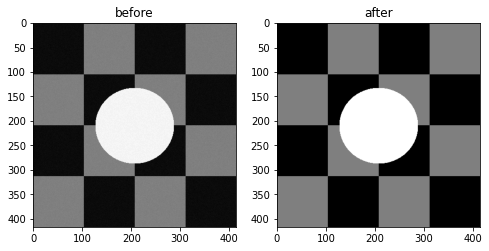

In [42]:
part_b(var=10)

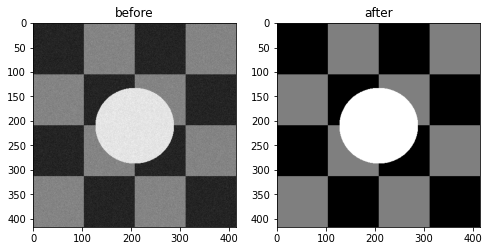

In [43]:
part_b(var=100)

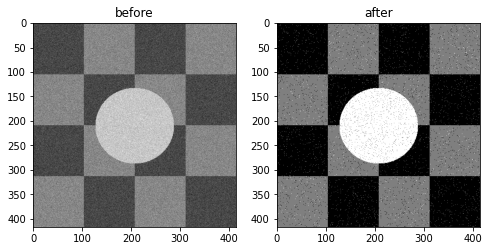

In [44]:
part_b(var=1000)

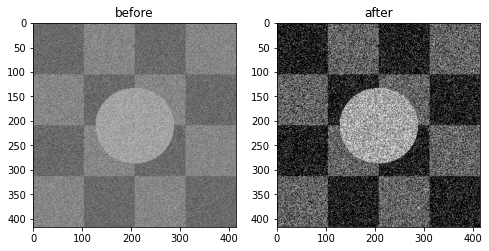

In [45]:
part_b(var=10000)

## Part C

In [61]:
class SimulatedAnnealing:

    def __init__(self, labels, image, class_info, neighbors_related_positions, iterations=1000, temperature=10000,
                 betha=1, schedule_coefficient=1, schedule_steps=1000):
        self.labels = labels
        self.image = image
        self.class_info = class_info
        self.iterations = iterations
        self.temperature = temperature
        self.neighbors_related_positions = neighbors_related_positions
        self.betha = betha
        self.schedule_coefficient = schedule_coefficient
        self.schedule_steps = schedule_steps

    def move(self, labels):
        new_classes = np.copy(CLASSES).tolist()

        random_index_x, random_index_y = random.randint(0, len(labels) - 1), random.randint(0, len(labels[0]) - 1)
        random_label = random.randint(0, len(new_classes) - 1)

        while labels[random_index_x][random_index_y] == random_label:
            random_label = random.randint(0, len(new_classes) - 1)
        return random_label, random_index_x, random_index_y

    def energy(self, new_labels, label, row, col):
        energy = 0.0
        class_mean = self.class_info[label].get('mean')
        class_var = self.class_info[label].get('var')
        energy += np.log(np.sqrt(2 * np.pi * class_var)) + ((label * 127 - class_mean) ** 2) / (2 * (class_var ** 2))
        neighbors_indexes = self.get_neighbours_indexes(row, col)
        for neighbor in neighbors_indexes:
            if neighbor[0] < len(new_labels) and neighbor[1] < len(new_labels[0]):
                energy += self.betha * self.are_different(label, new_labels[neighbor[0]][neighbor[1]])
        return energy

    def anneal(self, temperature_function):
        new_labels = np.copy(self.labels)
        temperature = self.temperature
        for i in range(self.iterations):
            random_label, random_row, random_col = self.move(new_labels)
            current_energy = self.energy(new_labels, new_labels[random_row][random_col], random_row, random_col)
            new_energy = self.energy(new_labels, random_label, random_row, random_col)
            delta_U = new_energy - current_energy
            random_uniform = random.uniform(0, 1)
            if self.is_eligible_to_update(delta_U, temperature, random_uniform):
                new_labels[random_row][random_col] = random_label
            temperature = temperature_function(temperature)
        return new_labels

    def get_neighbours_indexes(self, row, col):
        indexes = []
        for index in self.neighbors_related_positions:
            indexes.append((row + index[0], col + index[1]))

        return indexes

    @staticmethod
    def is_eligible_to_update(delta_U, temperature, random_uniform):
        return delta_U <= 0 or (delta_U > 0 and random_uniform < np.exp(-delta_U / temperature))

    @staticmethod
    def distance(a, b):
        return np.sqrt(np.sum(np.exp(a - b, 2)))

    @staticmethod
    def are_different(x, y):
        if x == y:
            return -1
        return 1

    def exponential_schedule(self, temperature):
        return temperature * 0.99

    def logarithmic_multiplicative_cooling_schedule(self, temperature):
        return temperature / (1 + self.schedule_coefficient * np.log(1 + self.schedule_steps))

    def linear_multiplicative_cooling_schedule(self, temperature):
        return temperature / (1 + self.schedule_coefficient * self.schedule_steps)


def get_match_percent(true_labels, new_labels):
    match_count = 0
    for i in range(len(true_labels)):
        for j in range(len(true_labels[0])):
            if true_labels[i][j] == new_labels[i][j]:
                match_count += 1
    return match_count / (len(true_labels) * len(true_labels[0]))


def plot_nb_and_sa(first, nb, sa):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 12))

    ax1.set_title('first')
    ax1.imshow(first, cmap='gray')

    ax2.set_title('Naive Bayes')
    ax2.imshow(nb, cmap='gray')

    ax3.set_title('Simulated Annealing')
    ax3.imshow(sa, cmap='gray')

    plt.show()

## Part D

In [67]:
def compare_nb_and_sa(var=100, betha=100, iterations=1000000, scheduler='exponential_schedule',
                      neighbors_related_positions=four_neighbors_related_positions):
    noisy_image = make_noisy(image=image, mean=0, var=var)
    noisy_labels = get_class_labels(noisy_image)
    class_info = get_class_information(noisy_image, true_labels)
    print("Noisy Match Percent: ", get_match_percent(true_labels, noisy_labels))

    nb_predicted_image = get_predicted_image(noisy_image, class_info)
    nb_predicted_labels = get_class_labels(nb_predicted_image)
    print("Naive Bayes Match Percent: ", get_match_percent(true_labels, nb_predicted_labels))

    simulated_annealer = SimulatedAnnealing(labels=noisy_labels, image=noisy_image, class_info=class_info,
                                            neighbors_related_positions=neighbors_related_positions,
                                            iterations=iterations,
                                            betha=betha)
    scheduler_function = {
        'exponential_schedule': simulated_annealer.exponential_schedule,
        'linear_multiplicative_cooling_schedule': simulated_annealer.linear_multiplicative_cooling_schedule,
        'logarithmic_multiplicative_cooling_schedule': simulated_annealer.logarithmic_multiplicative_cooling_schedule
    }
    optimized_labels = simulated_annealer.anneal(scheduler_function[scheduler])
    print("Simulated Annealing Match Percent: ", get_match_percent(true_labels, optimized_labels))

    plot_nb_and_sa(noisy_labels, nb_predicted_labels, optimized_labels)

Noisy Match Percent:  0.9999884429805553
Naive Bayes Match Percent:  1.0
Simulated Annealing Match Percent:  0.996290196758256


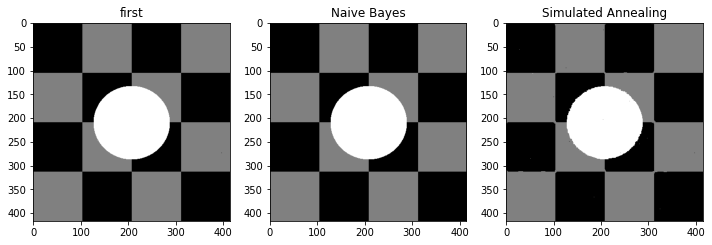

In [70]:
compare_nb_and_sa(var=100)

Noisy Match Percent:  0.9177082430441189
Naive Bayes Match Percent:  0.9714079338938488
Simulated Annealing Match Percent:  0.9487561757822658


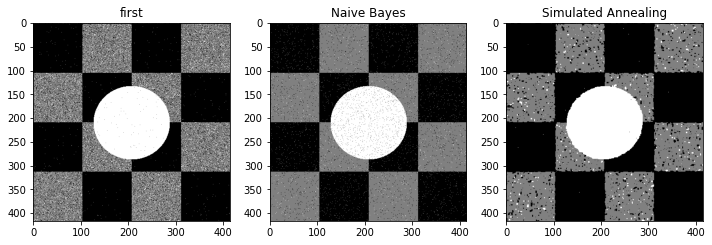

In [71]:
compare_nb_and_sa(var=1000)

Noisy Match Percent:  0.5905232440553582
Naive Bayes Match Percent:  0.6699141891306232
Simulated Annealing Match Percent:  0.7849354251538528


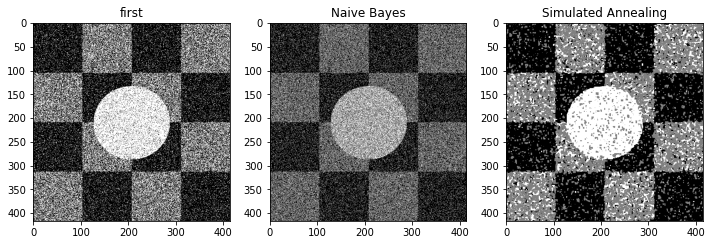

In [68]:
compare_nb_and_sa(var=10000)

## Part E

In [72]:
def compare_neighbors(var=100, betha=100, iterations=1000000, scheduler='exponential_schedule'):
    noisy_image = make_noisy(image=image, mean=0, var=var)
    noisy_labels = get_class_labels(noisy_image)
    class_info = get_class_information(noisy_image, true_labels)
    print("Noisy Match Percent: ", get_match_percent(true_labels, noisy_labels))

    simulated_annealer = SimulatedAnnealing(labels=noisy_labels, image=noisy_image, class_info=class_info,
                                            neighbors_related_positions=four_neighbors_related_positions,
                                            iterations=iterations,
                                            betha=betha)
    scheduler_function = {
        'exponential_schedule': simulated_annealer.exponential_schedule,
        'linear_multiplicative_cooling_schedule': simulated_annealer.linear_multiplicative_cooling_schedule,
        'logarithmic_multiplicative_cooling_schedule': simulated_annealer.logarithmic_multiplicative_cooling_schedule
    }
    four_optimized_labels = simulated_annealer.anneal(scheduler_function[scheduler])
    print("Four Neighbor Match Percent: ", get_match_percent(true_labels, four_optimized_labels))


    simulated_annealer = SimulatedAnnealing(labels=noisy_labels, image=noisy_image, class_info=class_info,
                                            neighbors_related_positions=eight_neighbors_related_positions,
                                            iterations=iterations,
                                            betha=betha)
    scheduler_function = {
        'exponential_schedule': simulated_annealer.exponential_schedule,
        'linear_multiplicative_cooling_schedule': simulated_annealer.linear_multiplicative_cooling_schedule,
        'logarithmic_multiplicative_cooling_schedule': simulated_annealer.logarithmic_multiplicative_cooling_schedule
    }
    eight_optimized_labels = simulated_annealer.anneal(scheduler_function[scheduler])
    print("Eight Neighbor Match Percent: ", get_match_percent(true_labels, eight_optimized_labels))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 12))

    ax1.set_title('Noisy')
    ax1.imshow(noisy_labels, cmap='gray')

    ax2.set_title('Four Neighbor')
    ax2.imshow(four_optimized_labels, cmap='gray')

    ax3.set_title('Eight Neighbor')
    ax3.imshow(eight_optimized_labels, cmap='gray')

    plt.show()

Noisy Match Percent:  0.9999768859611107
Four Neighbor Match Percent:  0.9968391551818786
Eight Neighbor Match Percent:  0.99770593164023


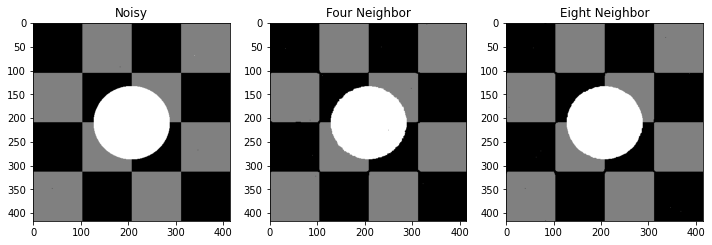

In [73]:
compare_neighbors(var=100)

Noisy Match Percent:  0.9192684406691515
Four Neighbor Match Percent:  0.9524833145531767
Eight Neighbor Match Percent:  0.9811909508537748


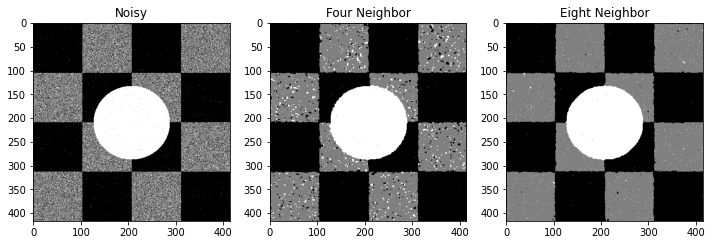

In [74]:
compare_neighbors(var=1000)

Noisy Match Percent:  0.5925399439484557
Four Neighbor Match Percent:  0.7845598220219006
Eight Neighbor Match Percent:  0.793152465979024


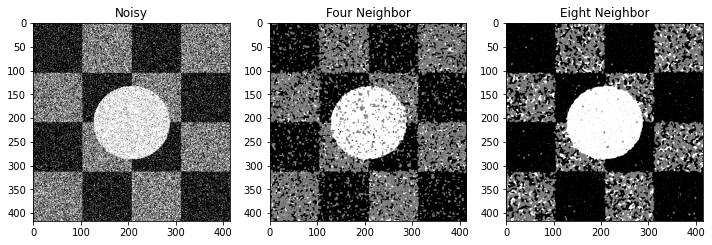

In [76]:
compare_neighbors(var=10000)

## Part F

In [103]:
def part_f(var=100, betha=100, iterations=1000000, scheduler='exponential_schedule'):
    noisy_image = make_noisy(image=image, mean=0, var=var)
    noisy_labels = get_class_labels(noisy_image)
    class_info = get_class_information(noisy_image, true_labels)
    print("Noisy Match Percent: ", get_match_percent(true_labels, noisy_labels))

    simulated_annealer = SimulatedAnnealing(labels=noisy_labels, image=noisy_image, class_info=class_info,
                                            neighbors_related_positions=four_neighbors_related_positions,
                                            iterations=iterations,
                                            betha=betha)
    scheduler_function = {
        'exponential_schedule': simulated_annealer.exponential_schedule,
        'linear_multiplicative_cooling_schedule': simulated_annealer.linear_multiplicative_cooling_schedule,
        'logarithmic_multiplicative_cooling_schedule': simulated_annealer.logarithmic_multiplicative_cooling_schedule
    }
    optimized_labels = simulated_annealer.anneal(scheduler_function[scheduler])
    print("Betha", betha, "Match Percent: ", get_match_percent(true_labels, optimized_labels))
    return get_match_percent(true_labels, optimized_labels)

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

#     ax1.set_title('Noisy')
#     ax1.imshow(noisy_labels, cmap='gray')

#     ax2.set_title('Beta ')
#     ax2.imshow(optimized_labels, cmap='gray')

#     plt.show()


Noisy Match Percent:  0.9183034295455202
Betha 0.1 Match Percent:  0.9912340007512063


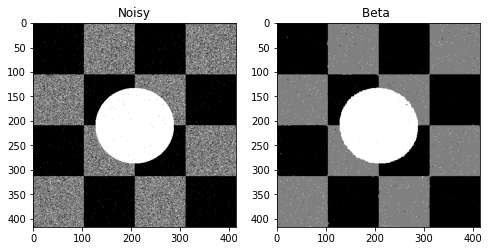

In [92]:
part_f(var=1000, betha = 0.1)

Noisy Match Percent:  0.9194649099997111
Betha 1 Match Percent:  0.9701077692063217


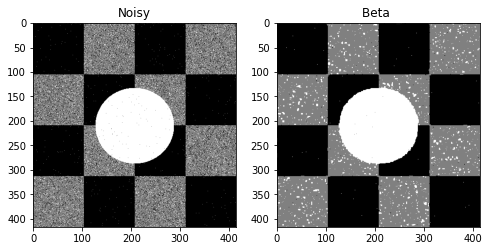

In [93]:
part_f(var=1000, betha = 1)

Noisy Match Percent:  0.9185981335413597
Betha 10 Match Percent:  0.9570714512727168


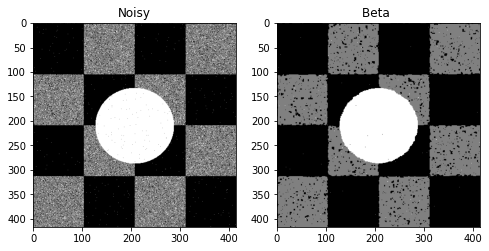

In [94]:
part_f(var=1000, betha = 10)

Noisy Match Percent:  0.9183438791135766
Betha 100 Match Percent:  0.9728005547369334


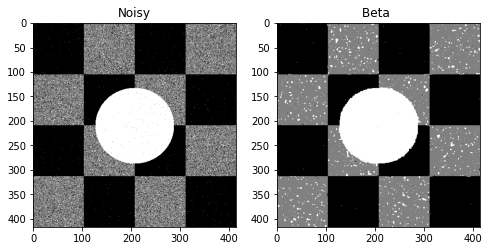

In [95]:
part_f(var=1000, betha = 100)

Noisy Match Percent:  0.9163560717690907
Betha 10000 Match Percent:  0.9577359798907862


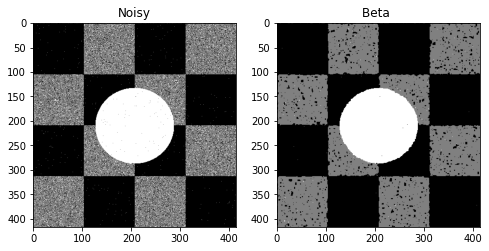

In [96]:
part_f(var=1000, betha = 10000)

In [105]:
bethas = [0.001, 0.01, 0.1, 1, 10 ,100]
match_percent = []
for betha in bethas:
    match_percent.append(part_f(var=10000, betha=betha))

Noisy Match Percent:  0.5926901852012366
Betha 0.001 Match Percent:  0.5275837161596024
Noisy Match Percent:  0.5930600098234665
Betha 0.01 Match Percent:  0.5881829476178093
Noisy Match Percent:  0.5905405795845251
Betha 0.1 Match Percent:  0.6218023171823986
Noisy Match Percent:  0.5911646586345382
Betha 1 Match Percent:  0.7818150299037878
Noisy Match Percent:  0.5930542313137442
Betha 10 Match Percent:  0.5769032966397966
Noisy Match Percent:  0.5901765334720176
Betha 100 Match Percent:  0.5662014966340181


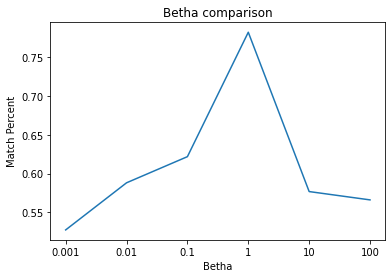

In [110]:
bethas = ['0.001', '0.01', '0.1', '1', '10' ,'100']
plt.plot(bethas, match_percent)
plt.title('Betha comparison')
plt.xlabel('Betha')
plt.ylabel('Match Percent')
plt.show()

## Part G

In [99]:
def compare_given_pixels(var, betha=10, iterations=1000000, scheduler='exponential_schedule',
                      neighbors_related_positions=four_neighbors_related_positions):
    noisy_image = make_noisy(image=image, mean=0, var=var)
    for i in range(int(len(noisy_image) / 2)):
        for j in range(int(len(noisy_image[0]) / 2)):
            noisy_image[i][j] = image[i][j]

    noisy_labels = get_class_labels(noisy_image)


    class_info = get_class_information(noisy_image, true_labels)
    print("Noisy Match Percent: ", get_match_percent(true_labels, noisy_labels))

    nb_predicted_image = get_predicted_image(noisy_image, class_info)
    nb_predicted_labels = get_class_labels(nb_predicted_image)
    print("Naive Bayes Match Percent: ", get_match_percent(true_labels, nb_predicted_labels))

    simulated_annealer = SimulatedAnnealing(labels=noisy_labels, image=noisy_image, class_info=class_info,
                                            neighbors_related_positions=neighbors_related_positions,
                                            iterations=iterations,
                                            betha=betha)
    scheduler_function = {
        'exponential_schedule': simulated_annealer.exponential_schedule,
        'linear_multiplicative_cooling_schedule': simulated_annealer.linear_multiplicative_cooling_schedule,
        'logarithmic_multiplicative_cooling_schedule': simulated_annealer.logarithmic_multiplicative_cooling_schedule
    }
    optimized_labels = simulated_annealer.anneal(scheduler_function[scheduler])
    print("Simulated Annealing Match Percent: ", get_match_percent(true_labels, optimized_labels))

    plot_nb_and_sa(noisy_labels, nb_predicted_labels, optimized_labels)

Noisy Match Percent:  0.7746438993383606
Naive Bayes Match Percent:  0.822212591372685
Simulated Annealing Match Percent:  0.932096732252752


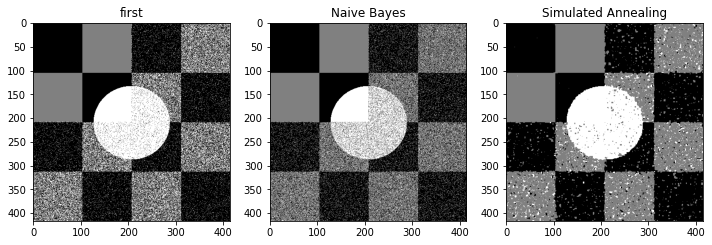

In [100]:
compare_given_pixels(var=5000)

## Part H

In [101]:
def part_h(var=1000, betha=100, iterations=1000000, scheduler='exponential_schedule'):
    noisy_image = make_noisy(image=image, mean=0, var=var)
    noisy_labels = get_class_labels(noisy_image)
    class_info = get_class_information(noisy_image, true_labels)
    print("Noisy Match Percent: ", get_match_percent(true_labels, noisy_labels))

    simulated_annealer = SimulatedAnnealing(labels=noisy_labels, image=noisy_image, class_info=class_info,
                                            neighbors_related_positions=four_neighbors_related_positions,
                                            iterations=iterations,
                                            betha=betha)
    scheduler_function = {
        'exponential_schedule': simulated_annealer.exponential_schedule,
        'linear_multiplicative_cooling_schedule': simulated_annealer.linear_multiplicative_cooling_schedule,
        'logarithmic_multiplicative_cooling_schedule': simulated_annealer.logarithmic_multiplicative_cooling_schedule
    }
    exponential_labels = simulated_annealer.anneal(scheduler_function[scheduler])
    print("Exponential Match Percent: ", get_match_percent(true_labels, exponential_labels))

    linear_multiplicative_labels = simulated_annealer.anneal(scheduler_function[scheduler])
    print("Linear Multiplicative Match Percent: ", get_match_percent(true_labels, linear_multiplicative_labels))

    logarithmic_multiplicative_labels = simulated_annealer.anneal(scheduler_function[scheduler])
    print("Logarithmic Multiplicative Match Percent: ", get_match_percent(true_labels, logarithmic_multiplicative_labels))

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 10))

    ax1.set_title('Noisy')
    ax1.imshow(noisy_labels, cmap='gray')

    ax2.set_title('Exponential')
    ax2.imshow(exponential_labels, cmap='gray')

    ax3.set_title('Linear Multiplicative')
    ax3.imshow(linear_multiplicative_labels, cmap='gray')

    ax4.set_title('Logarithmic Multiplicative')
    ax4.imshow(logarithmic_multiplicative_labels, cmap='gray')

    plt.show()


Noisy Match Percent:  0.9175580017913381
Exponential Match Percent:  0.9521019329115021
Linear Multiplicative Match Percent:  0.9510444656323134
Logarithmic Multiplicative Match Percent:  0.9508422177920315


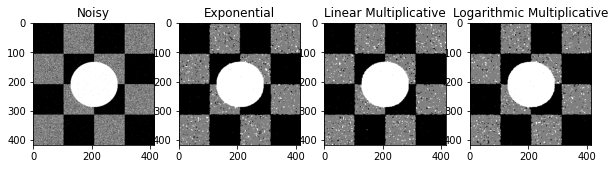

In [102]:
part_h()